# Практическое задание №6

- Попробуйте обучить нейронную сеть U-Net на любом другом датасете.
- Опишите результат. Что помогло повысить точность?
- *Попробуйте свои силы в задаче City Scapes на Kaggle - https://www.kaggle.com/dansbecker/cityscapes-image-pairs.
- *Сделайте свою реализацию U-Net на TensorFlow

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageOps
from sklearn.cluster import KMeans
import tensorflow as tf

# метрика Dice Coefficient
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*6)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
image_dir_val = 'C:/archive/cityscapes_data/train/'
image_dir_train = 'C:/archive/cityscapes_data/val/'

In [5]:
import os, fnmatch
images_train = os.listdir(image_dir_train)
images_val = os.listdir(image_dir_val)

Датасет Cityscapes. В данном датасете присутствуют исходные и сегментированные изображения.
https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs?resource=download

In [6]:
num_images_train = 2975
num_images_val = 500

X_train = []
y_train = []

X_val = []
y_val = []

In [7]:
for filename in images_train[:num_images_train]:
    image = Image.open(os.path.join(image_dir_train, filename))
    X_train.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_train.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))
    

for filename in images_val[:num_images_val]:
    image = Image.open(os.path.join(image_dir_val, filename))
    X_val.append(np.asarray(ImageOps.crop(image, (0, 0, 256, 0))))
    y_val.append(np.asarray(ImageOps.crop(image, (256, 0, 0, 0))))


X_train = np.array(X_train) / 255.
X_val = np.array(X_val) / 255.

y_train = np.array(y_train)
y_val = np.array(y_val)

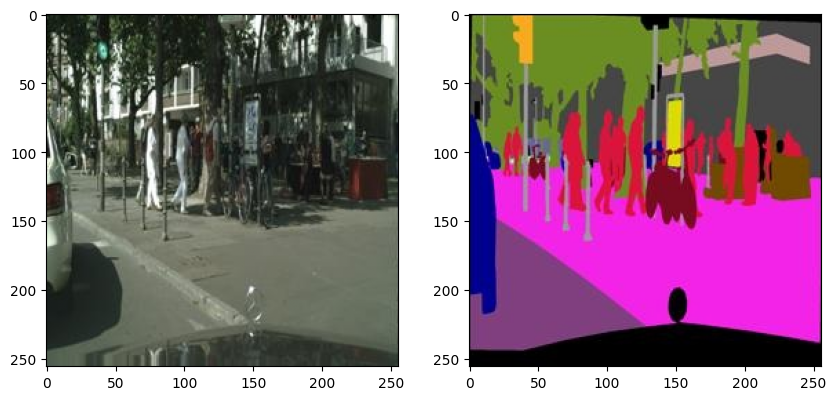

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(X_train[3])
axes[1].imshow(y_train[3])

In [9]:
num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)

# количество классов установил методом подбора
num_classes = 19
label_model = KMeans(n_clusters=num_classes, random_state=21)
label_model.fit(color_array)

KMeans(n_clusters=19, random_state=21)

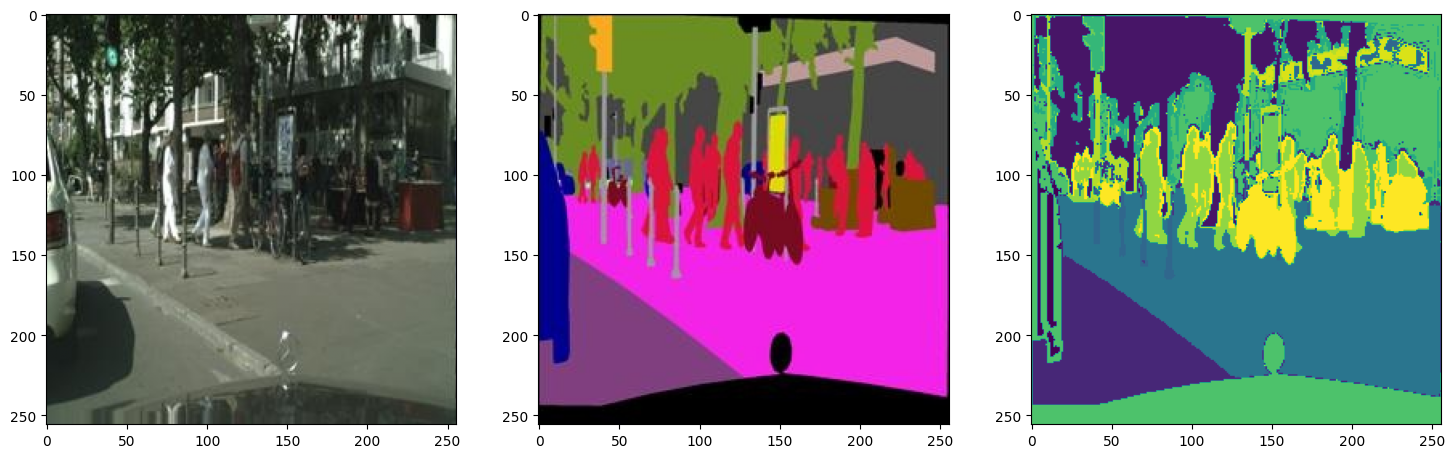

In [10]:
label_class = label_model.predict(y_train[3].reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(18, 9))
axes[0].imshow(X_train[3])
axes[1].imshow(y_train[3])
axes[2].imshow(label_class)
plt.show()

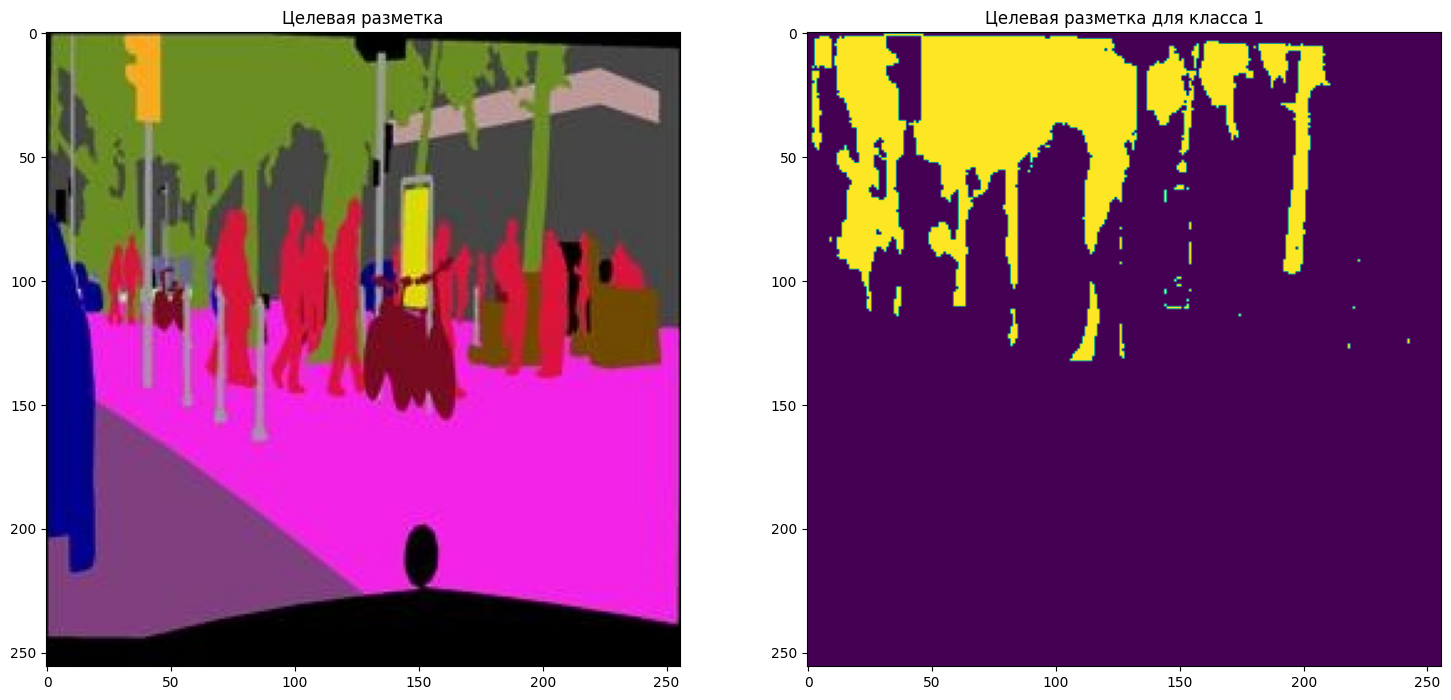

In [11]:
def Color2index(y, num_classes=19):
    arr_col = np.arange(0, num_classes)
    t = label_model.predict(y.reshape(-1, 3)).reshape(256, 256)
    y_cat = (arr_col == t[...,None]).astype(int)
    return y_cat, t

cat_yi,ind_yi = Color2index(y_train[3])

class_ = 2
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
axes[0].imshow(y_train[3,:,:,:])
axes[0].title.set_text('Целевая разметка')
axes[1].imshow(cat_yi[:,:,class_])
axes[1].title.set_text(f'Целевая разметка для класса {class_}')
plt.show() 

In [12]:
train_labels = []
val_labels = []

for mask in y_train:
    y_cat,_ = Color2index(mask)
    train_labels.append(y_cat)


for mask in y_val:
    y_cat,_ = Color2index(mask)
    val_labels.append(y_cat)
    
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [13]:
train_labels.shape

(500, 256, 256, 19)

## Базовая модель

In [14]:
def Unet(num_classes=19, input_shape=(256, 256, 3), act_func='relu'):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation(act_func)(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation(act_func)(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation(act_func)(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation(act_func)(x)

    # UP 1
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # UP 2
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # UP 3
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [15]:
super_model = Unet(19, (256, 256, 3))
# plot_model(super_model, to_file='super_model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [16]:
def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('super_model.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    early=tf.keras.callbacks.EarlyStopping(monitor='loss',patience=patience)
    callbacks_list=[checkpoint, early]
    return callbacks_list

In [17]:
%%time

history = super_model.fit(X_train, train_labels, epochs=40, batch_size=2, validation_data=(X_val, val_labels), callbacks=callbacks())

Epoch 1/40
250/250 [==============================] - ETA: 0s - loss: 1.1698 - dice_coef: 0.5045
Epoch 1: loss improved from inf to 1.16984, saving model to super_model.h5
250/250 [==============================] - 124s 443ms/step - loss: 1.1698 - dice_coef: 0.5045 - val_loss: 6.0922 - val_dice_coef: 0.3507
Epoch 2/40
250/250 [==============================] - ETA: 0s - loss: 1.0214 - dice_coef: 0.5548
Epoch 2: loss improved from 1.16984 to 1.02141, saving model to super_model.h5
250/250 [==============================] - 109s 437ms/step - loss: 1.0214 - dice_coef: 0.5548 - val_loss: 2.2259 - val_dice_coef: 0.4507
Epoch 3/40
250/250 [==============================] - ETA: 0s - loss: 0.9682 - dice_coef: 0.5724
Epoch 3: loss improved from 1.02141 to 0.96823, saving model to super_model.h5
250/250 [==============================] - 113s 453ms/step - loss: 0.9682 - dice_coef: 0.5724 - val_loss: 1.0931 - val_dice_coef: 0.6055
Epoch 4/40
250/250 [==============================] - ETA: 0s - l

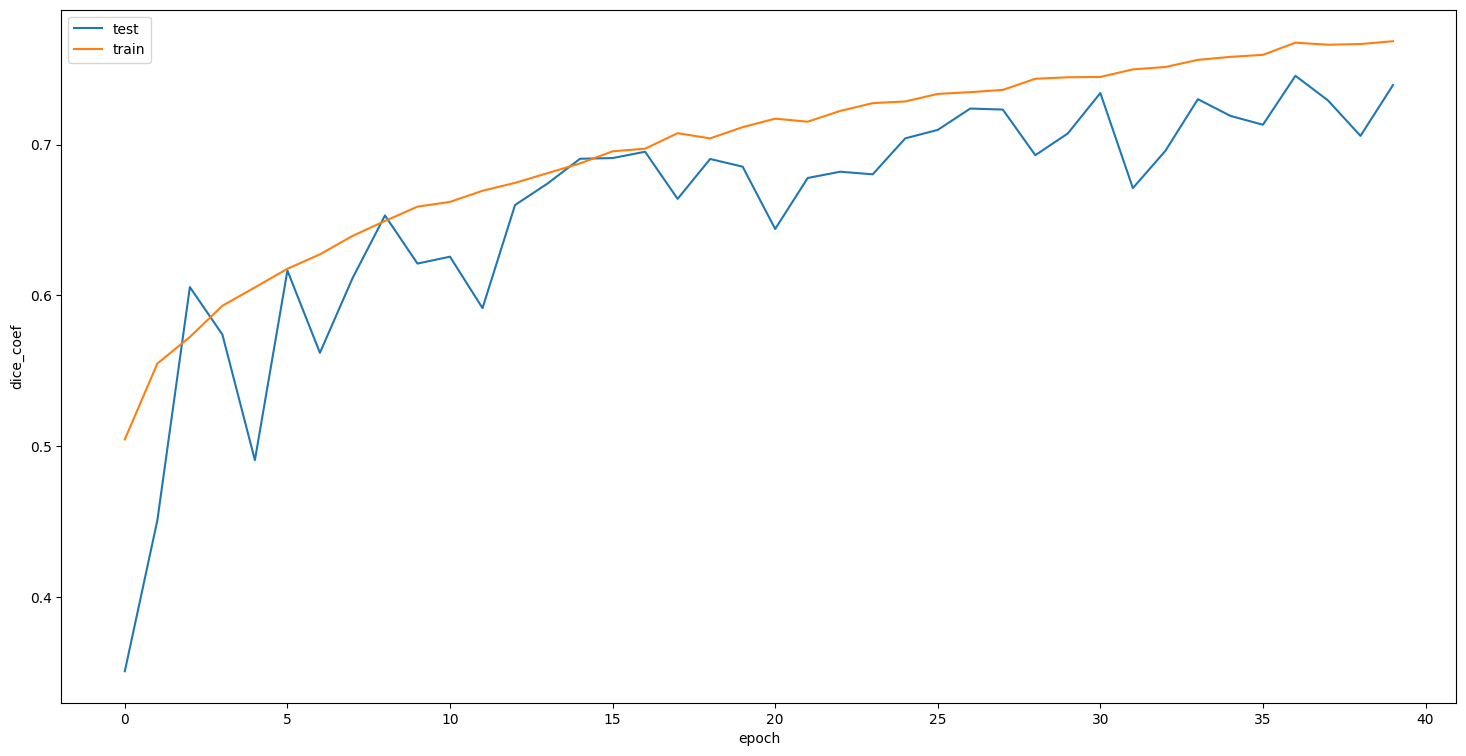

In [18]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Дальше 0.7395 тест метрики похоже не улучшаются

## Тюнинг модели

Пробую изменять функцию активации, оптимизатор, коэффициент скорости обучения, количество ядер, количество слоев.

In [19]:
def Unet(num_classes=19, input_shape=(256, 256, 3), act_func='relu'):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation(act_func)(x)

    x = MaxPooling2D()(block_1_out) 

    # Block 2
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation(act_func)(x)

    x = MaxPooling2D()(block_2_out) 

    # Block 3
    x = Conv2D(128, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(128, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation(act_func)(x)

    x = MaxPooling2D()(block_3_out) 

    # Block 4
    x = Conv2D(256, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(256, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(256, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation(act_func)(x)
    
    x = MaxPooling2D()(block_4_out)
    
    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_4_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(act_func)(x) 
    
    
    # слой классификатор
    x = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=SGD(learning_rate=1e-2),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [20]:
super_model = Unet(19, (256, 256, 3), act_func='relu')
# plot_model(super_model, to_file='super_model.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 256, 256, 32  128        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [21]:
%%time

history = super_model.fit(X_train, train_labels, epochs=100, batch_size=2, validation_data=(X_val, val_labels), callbacks=callbacks())

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 1.6561 - dice_coef: 0.3537
Epoch 1: loss improved from inf to 1.65607, saving model to super_model.h5
250/250 [==============================] - 103s 388ms/step - loss: 1.6561 - dice_coef: 0.3537 - val_loss: 2.9670 - val_dice_coef: 0.3157
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 1.1725 - dice_coef: 0.5177
Epoch 2: loss improved from 1.65607 to 1.17249, saving model to super_model.h5
250/250 [==============================] - 92s 370ms/step - loss: 1.1725 - dice_coef: 0.5177 - val_loss: 2.1002 - val_dice_coef: 0.3645
Epoch 3/100
250/250 [==============================] - ETA: 0s - loss: 1.0825 - dice_coef: 0.5459
Epoch 3: loss improved from 1.17249 to 1.08253, saving model to super_model.h5
250/250 [==============================] - 93s 375ms/step - loss: 1.0825 - dice_coef: 0.5459 - val_loss: 1.1115 - val_dice_coef: 0.5304
Epoch 4/100
250/250 [==============================] - ETA: 0s -

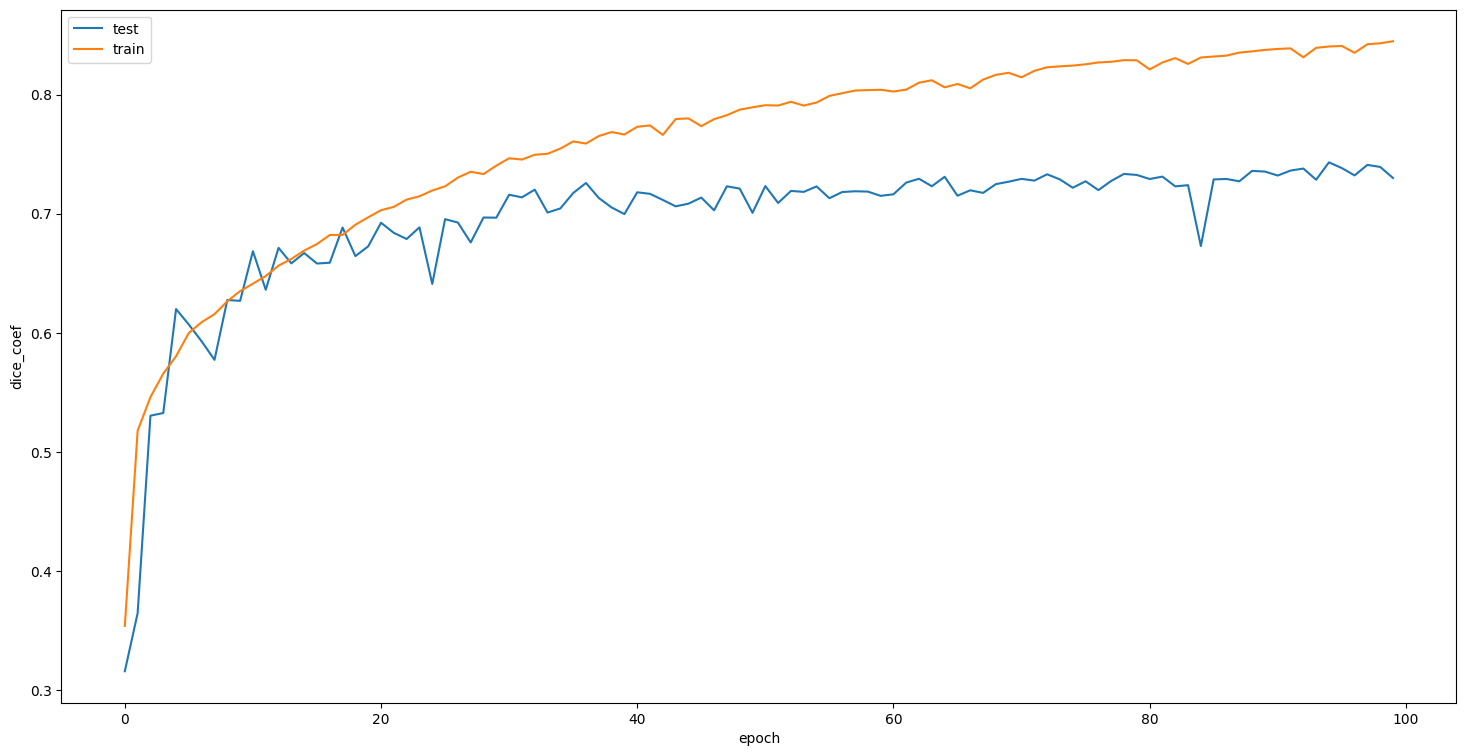

In [22]:
plt.figure(figsize=(18, 9))
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

In [25]:
pred = super_model.predict(X_val[0:1])

1/1 [==============================] - 1s 652ms/step


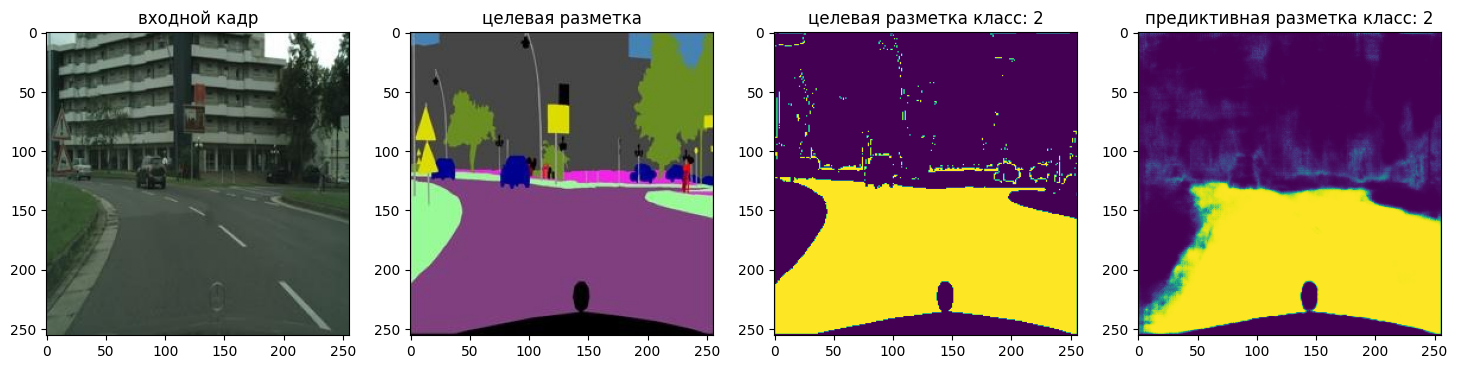

In [44]:
class_ = 2
fig, axes = plt.subplots(1, 4, figsize=(18, 9))
axes[0].imshow(X_val[0])
axes[0].title.set_text('входной кадр')
axes[1].imshow(y_val[0])
axes[1].title.set_text('целевая разметка')
axes[2].imshow(val_labels[0][:,:,class_])
axes[2].title.set_text('целевая разметка класс: '+str(class_))
axes[3].imshow(pred[0][:,:,class_])
axes[3].title.set_text('предиктивная разметка класс: '+str(class_))
plt.show()

Улучшить метрику получилось, увеличив количество пар слоев, уменьшив количество ядер первого и последующих слоев. Также помогло - изменение оптимизатора и тюнинг скорости обучения.

Кроме того, видно, что последующее увеличение количества эпох может привести к улучшению модели.